# Summarization

- Author: [Erika Park](https://www.linkedin.com/in/yeonseo-park-094193198/)
- Peer Review: 
- Proofread:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/01-Basic/05-Using-OpenAIAPI-MultiModal.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/01-Basic/05-Using-OpenAIAPI-MultiModal.ipynb)

## Overview

### Key Summarization Techniques

In this tutorial, we will explore various document summarization techniques, discussing their approaches and applications.

- Stuff: Summarizing the entire document at once by feeding it directly into the LLM's context window. This is the simplest and most straightforward method.

- Map-Reduce: Splitting a document into multiple chunks, summarizing each chunk individually (map), and then merging the summaries into a final summary (reduce).

- Map-Refine: Splitting a document into chunks, summarizing each one, and then progressively refining the summary by referencing previous summaries.

- Chain of Density: Repeatedly summarizing a document while filling in missing entities, progressively improving the summary quality.

- Clustering-Map-Refine: Dividing a document into N clusters, summarizing a central document from each cluster, and then refining the cluster summaries for a comprehensive result.


### Core Principles of Document Summarization

A central question when building a summarizer is: How should the document be presented to the LLM's context window? <br>
The primary approaches include:

1. `Stuff` (Full Input): Placing the entire document into the context window at once. Simple but limited when handling long documents.

2. `Map-Reduce` (Chunk and Merge): Splitting the document into multiple chunks, summarizing each chunk, and then merging the results into a final summary. Useful for handling large datasets.

3. `Refine` (Sequential Improvement): Processing the document sequentially and refining the summary by merging previous summaries with new content, making it effective for detailed summarization needs.

By the end of this tutorial, you will understand how to use these techniques effectively and choose the right method for your specific summarization scenarios.

<br>

**Document Used for Practice**
 
[Artificial Intelligence Index Report 2024 (Standford University)](https://arxiv.org/abs/2405.19522)
- Authors: Erik Brynjolfsson, John Etchemendy, Juan Carlos Niebles, Vanessa Parli, Yoav Shoham, Russell Wald (Stanford University); Katrina Ligett (Hebrew University); Terah Lyons (JPMorgan Chase & Co.); James Manyika (Google, University of Oxford); Juan Carlos Niebles (Salesforce); Yoav Shoham (AI21 Labs)
- File Name: "Artificial Intelligence Index Report.pdf"

_Please copy the downloaded file to the data folder for practice._


### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Stuff](#stuff)
- [Map-Reduce](#map-reduce)
- [Map-Refine](#map-refine)
- [Chain of Density (CoD)](#chain-of-density-cod)
- [Clustering-Map-Refine](#clustering-map-refine)

### References

- [LangChain Summarize Text](https://python.langchain.com/v0.2/docs/tutorials/summarization/)
- [Document Summarization with LangChain (3 Easy Methods)](https://lancerninja.com/document-summarization-with-langchain/?utm_source=chatgpt.com)
<br><br>
----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions, and utilities for tutorials. 
- You can checkout out the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain",
        "langchain_community",
        "langchain_openai",
        "langchain_core",
        "langchain_upstage",
        "scikit-learn",
        "matplotlib",
        "seaborn",
        "numpy"
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        # "OPENAI_API_KEY": "",
        # "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Chain_Summary",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Configuration file to manage the API KEY as an environment variable
from dotenv import load_dotenv

# Load API KEY information
load_dotenv(override=True)

True

## Stuff

The `stuff documents chain` (where "stuff" means "to fill" or "for filling") is the simplest type of document chain. It takes a list of documents, inserts them all into the prompt, and then sends that prompt to the LLM.

In other words, the `context` input directly receives `Document` objects. When using a retriever to search a vector_store, it returns a `List[Document]`. This chain automatically converts the documents into a format suitable for the LLM without requiring manual conversion to strings.

This chain is suitable for applications where documents are small, and only a few are passed in most calls.

In [5]:
# Loading the text data
from langchain_community.document_loaders import TextLoader

# Load news data
loader = TextLoader("data/news.txt")
docs = loader.load()
print(f"Total characters: {len(docs[0].page_content)}")
print("\n========= Preview =========\n")
print(docs[0].page_content[:500])

Total characters: 6235

========= Preview =========

Title: 5 Generative AI Trends To Watch Out For In 2025

Content:
As businesses navigate an increasingly digital landscape, generative AI is becoming the cornerstone of enterprise applications. 
This transformation promises to enhance operational efficiency, drive innovation and reshape how organizations interact with technology. 
Understanding these shifts is crucial for executives and technology leaders who aim to stay competitive in a rapidly evolving market.
Here are five key generative AI tr


The following prompt is designed to generate concise and effective summaries by guiding the language model with clear instructions. 

In [6]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    input_variables=["context"],
    template=(
        "Summarize the following text clearly and concisely.\n\n"
        "When summarizing, keep the following in mind:\n"
        "- Include key events, facts, and critical information.\n"
        "- Omit unnecessary details.\n"
        "- Limit the summary to three sentences.\n\n"
        "Text to summarize:\n{context}\n\n"
        "Summary:"
        )
    )
prompt.pretty_print()

Summarize the following text clearly and concisely.

When summarizing, keep the following in mind:
- Include key events, facts, and critical information.
- Omit unnecessary details.
- Limit the summary to three sentences.

Text to summarize:
{context}

Summary:


The following function can be used for streaming token output, useful for callback handling when working with LLMs.
* A **callback** is a mechanism that allows specific actions to be executed each time a new token is generated by the LLM. This can be useful for streaming token outputs in real-time.

In [7]:
from langchain_core.callbacks import BaseCallbackHandler

class StreamingCallback(BaseCallbackHandler):
    def __init__(self):
        self.buffer = ""  # Initialize sentence buffer

    def on_llm_new_token(self, token: str, **kwargs) -> None:
        self.buffer += token
        if token in {".", "!", "?"}:  # Print only when a sentence-ending character appears
            print(self.buffer.strip())
            self.buffer = ""  # Clear the buffer


In [8]:
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import create_stuff_documents_chain

# Initialize the OpenAI object.
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    streaming=True,
    temperature=0,
    callbacks=[StreamingCallback()],
)

# Create a "stuff" document chain.
# This chain inserts all documents into the prompt and sends it to the LLM.
stuff_chain = create_stuff_documents_chain(llm, prompt)

# Execute the chain
answer = stuff_chain.invoke({"context": docs})

Generative AI is set to transform enterprise applications by becoming integral to their design, moving from AI-infused to AI-first applications, which will enhance operational efficiency and innovation.
Key trends for 2025 include the rise of service as software, real-time speech integration, generative user interfaces, and the embedding of AI agents into workflows, which will automate tasks and improve user interactions.
These advancements will require businesses to adapt their internal processes and pricing models to leverage the full potential of generative AI.


## Map-Reduce

Map-reduce summarization is an effective technique for condensing lengthy documents.<br>
This method involves two primary stages:

1. **Map Stage**: The document is divided into smaller chunks, each of which is summarized independently.
2. **Reduce Stage**: The individual summaries are then combined to form a cohesive final summary.

This approach is particularly advantageous when dealing with extensive documents, as it allows for parallel processing of chunks during the map stage, thereby enhancing efficiency. Additionally, it helps circumvent the token limitations inherent in language models by ensuring that each chunk fits within the model's context window.

<img src="./assets/01-summary-summarization-use-case-1.png" alt="rag-flow" width="900" >

* [Image source](https://python.langchain.com/v0.2/docs/tutorials/summarization/)
<br>


In this section, we will use the "Artificial Intelligence Index Report.pdf" to carry out the Map phase and the Reduce phase.

Load the downloaded data

In [9]:
from langchain_community.document_loaders import PyPDFLoader

# Load the PDF file using PyPDFLoader
loader = PyPDFLoader("data/Artificial Intelligence Index Report.pdf")

# load the document
docs = loader.load()
docs = docs[3:8]  # Select only a portion of the document for summarization(pages 3 to 8))

print(f"Total number of pages: {len(docs)}")

Total number of pages: 5


### Map Stage

During the map stage, each chunk is typically processed by generating a summary.

While the standard approach involves summarizing the content of each chunk, an alternative method is to extract key information instead. <br>
Since the reduce stage ultimately combines the outputs into a final summary, both approaches can be effective with minimal impact on the final result.

The choice between summarization and key information extraction during the map stage can be adjusted based on the specific goals and requirements of the task.

In [10]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# initialize the model
llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# Download the map prompt from the LangChain hub
map_prompt = hub.pull("teddynote/map-prompt")

# print the content of the prompt
map_prompt.pretty_print()

================================ System Message ================================

You are a professional main thesis extractor.

================================ Human Message =================================

Your task is to extract main thesis from given documents. Answer should be in same language as given document. 

#Format: 
- thesis 1
- thesis 2
- thesis 3
- ...

Here is a given document: 
{doc}

Write 1~5 sentences.
#Answer:


In [11]:
# Create the map chain
map_chain = map_prompt | llm | StrOutputParser()

Generate summaries for each document using `batch()` processing

In [12]:
# Extract key content for a document
doc_summaries = map_chain.batch(docs)

In [13]:
# Generate summaries for each document using batch processing
len(doc_summaries)

5

In [14]:
# Display the summary of the first document
print(doc_summaries[0])

- A global decrease in private investment in AI was observed for the second consecutive year, while investment in generative AI significantly increased.  
- The frequency of AI mentions in Fortune 500 earnings calls reached an all-time high, indicating a growing recognition of AI's impact on productivity.  
- Legislative discussions surrounding AI have surged, with U.S. regulators implementing more AI-related regulations in 2023 than in previous years.  
- Despite the advancements, there are rising concerns about AI's potential to create deepfakes and influence elections, leading to increased public anxiety regarding the technology.  
- Overall, the public's awareness of AI has grown, accompanied by a sense of nervousness about its implications.


### Reduce Stage
To create a **Reduce Chain**, the results generated during the **map** stage are further processed to combine and refine them into a final cohesive summary.

Here's an example of how to create a Reduce Chain using LangChain:

In [15]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# Initialize the language model
llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

# Load the reduce prompt from the LangChain hub
reduce_prompt = hub.pull("teddynote/reduce-prompt")

reduce_prompt.pretty_print()

================================ System Message ================================

You are a professional summarizer. You are given a list of summaries of documents and you are asked to create a single summary of the documents.

================================ Human Message =================================

#Instructions: 
1. Extract main points from a list of summaries of documents
2. Make final summaries in bullet points format.
3. Answer should be written in {language}.

#Format: 
- summary 1
- summary 2
- summary 3
- ...

Here is a list of summaries of documents: 
{doc_summaries}

#SUMMARY:


In [16]:
# Create the reduce chain by combining the reduce prompt, LLM, and output parser
reduce_chain = reduce_prompt | llm | StrOutputParser()

In [17]:
# streaming using Reduce Chain
answer = reduce_chain.stream(
    {"doc_summaries": "\n".join(doc_summaries), # Combine summaries into a single string
     "language": "English"}
)
for chunk in answer:
    print(chunk, end="", flush = True)

- A global decline in private investment in AI was noted for the second year, while generative AI investment rose significantly.
- AI mentions in Fortune 500 earnings calls reached a record high, reflecting increased recognition of AI's productivity impact.
- Legislative activity around AI has intensified, with U.S. regulators implementing more AI-related regulations in 2023 than in previous years.
- Concerns about AI's potential to create deepfakes and influence elections are rising, contributing to public anxiety about the technology.
- Public awareness of AI has increased, accompanied by growing nervousness regarding its implications.
- AI has outperformed humans in certain benchmarks but still faces challenges with complex tasks.
- Industry is the main driver of frontier AI research, significantly outpacing academic contributions.
- The costs of training advanced AI models have reached unprecedented levels.
- The United States remains the leading source of significant AI models, fa

**Full Implementation of the Map-Reduce Chain**

The following code combines both the map and reduce stages for summarizing documents using LangChain. 

In [18]:
from langchain_core.runnables import chain
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

@chain
def map_reduce_chain(docs):
    # Initialize the language model for the map stage
    map_llm = ChatOpenAI(
        temperature=0,
        model_name="gpt-4o-mini",
    )

    # Load the map prompt from the LangChain hub
    map_prompt = hub.pull("teddynote/map-prompt")

    # Create the map chain by combining the prompt, LLM, and output parser
    map_chain = map_prompt | map_llm | StrOutputParser()

    # Generate summaries for each document using batch processing
    doc_summaries = map_chain.batch(docs)

    # Load the reduce prompt from the LangChain hub
    reduce_prompt = hub.pull("teddynote/reduce-prompt")

    # Initialize the language model for the reduce stage with streaming enabled
    reduce_llm = ChatOpenAI(
        model_name="gpt-4o",
        temperature=0,
        callbacks=[StreamingCallback()],
        streaming=True,
    )

    # Create the reduce chain to combine document summaries into a final summary
    reduce_chain = reduce_prompt | reduce_llm | StrOutputParser()

    # Return the final summary by combining all document summaries
    return reduce_chain.invoke(
        {"doc_summaries": "\n".join(doc_summaries), "language": "English"}
    )


In [19]:
# print result
answer = map_reduce_chain.invoke(docs)

- There has been a global decrease in private investment in AI for the second year, but investment in generative AI has increased.
- AI mentions in Fortune 500 earnings calls have reached an all-time high, showing its growing impact on productivity.
- Legislative discussions and regulations on AI have surged, with the U.S.
implementing more AI-related regulations in 2023 than ever before.
- Concerns about AI's potential to create deepfakes and influence elections are rising, leading to increased public anxiety.
- Public awareness of AI has grown, with a mix of recognition and nervousness about its implications.
- AI has surpassed human performance in some benchmarks but struggles with complex tasks.
- Industry leads in frontier AI research, outpacing academic contributions.
- Training state-of-the-art AI models has become increasingly costly.
- The U.S.
is the leading source of notable AI models, ahead of China and the EU.
- There is a lack of standardized evaluations for responsible A

## Map-Refine

The **Map-Refine** method is another approach for document summarization, similar to **Map-Reduce** but with some key differences in how summaries are processed and combined. 

1. **Map Stage:**
   - The document is divided into multiple smaller chunks.
   - Each chunk is independently summarized.

2. **Refine Stage:**
   - The generated summaries are processed sequentially.
   - In each iteration, the previous summary is combined with the next chunk's information to update and refine the summary.

3. **Iterative Process:**
   - The refine stage continues iteratively until all chunks have been processed.
   - Each iteration enhances the summary by incorporating more information while retaining previously captured details.

4. **Final Summary:**
   - Once all chunks have been processed, the final summary is obtained after the last refinement step.

**Key Advantages:**

- Maintains Document Order: This method preserves the original order of the document, making it particularly useful for content where sequence matters.
- Contextual Refinement: Each step progressively improves the summary, making it ideal for content where a gradual build-up of context is necessary.

**Limitations:**
- Sequential Processing: The refine stage requires sequential steps, making parallelization difficult.
- Time-Consuming: Due to its non-parallel nature, it can be slower compared to **Map-Reduce**, especially for large datasets.

**Use Cases:**
- Processing technical manuals or research papers where context builds across sections.
- Summarizing meeting transcripts where events unfold in chronological order.


<img src="./assets/01-summary-summarization-use-case-2.png" alt="rag-flow" width="900">

* [Image source](https://python.langchain.com/v0.2/docs/tutorials/summarization/)

### Map Stage

During the **map stage**, a summary is generated for each individual chunk of the document. This step involves processing the content of each chunk separately, ensuring that key information from every section is captured independently before moving on to the next stage.

In [20]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# Create map llm 
map_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# Create map chain 
map_summary = hub.pull("teddynote/map-summary-prompt")

# print prompt
map_summary.pretty_print()

================================ System Message ================================

You are an expert summarizer. Your task is to summarize the following document in {language}.

================================ Human Message =================================

Extract most important main thesis from the documents, then summarize in bullet points.

#Format:
- summary 1
- summary 2
- summary 3
-...

Here is a given document: 
{documents}

Write 1~5 sentences. Think step by step.
#Summary:


In [21]:
# Create map_chain
map_chain = map_summary | llm | StrOutputParser()

In [22]:
# Print the Summary of the First Document
print(map_chain.invoke({"documents": docs[0], "language": "English"}))

- Global private investment in AI has decreased for the second year, but investment in generative AI has significantly increased.
- There has been a record number of mentions of AI in Fortune 500 earnings calls and legislative proceedings, indicating heightened interest and awareness.
- U.S. regulators enacted more AI-related regulations in 2023 than in previous years, reflecting growing concerns about AI's potential risks, such as deepfakes and election interference.
- Public awareness of AI has risen, but this has also led to increased nervousness among the population regarding its implications.


In [23]:
# Define three documents as input
input_doc = [{"documents": doc, "language": "English"} for doc in docs[:3]]

In [24]:
# Check Input Documents 
input_doc

[{'documents': Document(metadata={'source': 'data/Artificial Intelligence Index Report.pdf', 'page': 3}, page_content='Artificial Intelligence\nIndex Report 20244Although global private investment in AI decreased for the second consecutive year, investment in generative \nAI skyrocketed. More Fortune 500 earnings calls mentioned AI than ever before, and new studies show that AI \ntangibly boosts worker productivity. On the policymaking front, global mentions of AI in legislative proceedings \nhave never been higher. U.S. regulators passed more AI-related regulations in 2023 than ever before. Still, many \nexpressed concerns about AI’s ability to generate deepfakes and impact elections. The public became more \naware of AI, and studies suggest that they responded with nervousness.\nRay Perrault and Jack Clark\nCo-directors, AI IndexMessage From the  \nCo-directors (cont’d)'),
  'language': 'English'},
 {'documents': Document(metadata={'source': 'data/Artificial Intelligence Index Report

In [25]:
# Print Summaries for All Documents
print(map_chain.batch(input_doc))

["- Global private investment in AI has decreased for the second year, but investment in generative AI has significantly increased.\n- There has been a record number of mentions of AI in Fortune 500 earnings calls and legislative proceedings, indicating heightened interest and awareness.\n- U.S. regulators enacted more AI-related regulations in 2023 than in previous years, reflecting growing concerns about AI's potential risks, such as deepfakes and election interference.\n- Public awareness of AI has risen, but this has also led to increased nervousness among the population regarding its implications.", "- AI has outperformed humans in specific tasks like image classification and language understanding, but struggles with complex challenges such as advanced mathematics and visual reasoning.\n- The majority of significant AI research is driven by industry, with 51 notable machine learning models developed by companies compared to only 15 from academia in 2023.\n- The costs associated w

>[ "- Global private investment in AI has decreased for the second year, but investment in generative AI has significantly increased.<br>
>    \- There has been a record number of mentions of AI in Fortune 500 earnings calls and legislative proceedings, indicating heightened interest and awareness.<br>
>    \- U.S. regulators enacted more AI-related regulations in 2023 than in previous years, reflecting growing concerns about AI's potential risks, such as deepfakes and election interference.<br>
>    \- Public awareness of AI has risen, but this has also led to increased nervousness among the population regarding its implications.", <br>
>  <br>
>  "- AI has outperformed humans in specific tasks like image classification and language understanding, but struggles with complex tasks such as advanced mathematics and planning.<br>
>  \- The majority of significant AI research is driven by industry, with 51 notable machine learning models produced by industry compared to only 15 from academia in 2023.<br>
>  \- The costs associated with training state-of-the-art AI models have surged, with examples like OpenAI's GPT-4 costing approximately $78 million and Google's Gemini Ultra costing around $191 million.<br>
>  \- The U.S. remains the leading source of top AI models, producing 61 notable models in 2023, significantly ahead of the EU and China.<br>
>  \- There is a critical lack of standardized evaluations for responsible AI, complicating the comparison of risks and limitations across different models.<br>
>  \- Investment in generative AI has dramatically increased, reaching $25.2 billion in 2023, despite a general decline in overall AI private investment.<br>
>  \- Studies indicate that AI enhances worker productivity and quality of work, although improper use of AI can negatively impact performance.", <br>
> <br>
>  \- "AI is significantly advancing scientific discovery, with notable applications launched in 2023, such as AlphaDev and GNoME.<br>
>  \- The number of AI-related regulations in the U.S. has surged, increasing from one in 2016 to 25 in 2023, with a 56.3% growth in the past year alone.<br>
>  \- Global awareness of AI's potential impact is rising, with 66% of people believing it will dramatically affect their lives in the next few years, and 52% expressing nervousness towards AI products and services."]

### Refine Stage

During the **refine stage**, the chunks generated in the previous map stage are processed sequentially, progressively improving the final summary with each iteration. The summary is updated by combining the information from the previous summary with the next chunk, ensuring a more comprehensive and contextually accurate final result.

In [26]:
# Downlod refine prompt 
refine_prompt = hub.pull("teddynote/refine-prompt")

# print the prompt
refine_prompt.pretty_print()

================================ System Message ================================

You are an expert summarizer.

================================ Human Message =================================

Your job is to produce a final summary

We have provided an existing summary up to a certain point:
{previous_summary}

We have the opportunity to refine the existing summary(only if needed) with some more context below.
------------
{current_summary}
------------
Given the new context, refine the original summary in {language}.
If the context isn't useful, return the original summary.


In [27]:
refine_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# create refine chain
refine_chain = refine_prompt | refine_llm | StrOutputParser()

The following code demonstrates how to create a `map_refine_chain` that combines both the map and refine stages into a single, streamlined process for document summarization.

In [28]:
from langchain_core.runnables import chain
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

@chain
def map_refine_chain(docs):
    
    # 1. Map Phase (Initial Summarization)
    
    # Load the predefined map-summary prompt from LangChain Hub
    map_summary = hub.pull("teddynote/map-summary-prompt")

    # Create the map chain combining the prompt, language model, and output parser
    map_chain = (
        map_summary
        | ChatOpenAI(
            model_name="gpt-4o-mini",
            temperature=0,  # Set deterministic output for consistency
        )
        | StrOutputParser()
    )

    # Prepare the input documents with a language specification for batch processing
    input_doc = [{"documents": doc.page_content, "language": "English"} for doc in docs]

    # Generate initial summaries for all document chunks using batch processing
    doc_summaries = map_chain.batch(input_doc)

    # 2. Refine Phase (Progressive Refinement)
    
    # Load the predefined refine prompt from LangChain Hub
    refine_prompt = hub.pull("teddynote/refine-prompt")
    
    # Initialize the language model for the refine phase with streaming enabled
    refine_llm = ChatOpenAI(
        model_name="gpt-4o-mini",
        temperature=0,
        callbacks=[StreamingCallback()],  # Enables real-time streaming of outputs
        streaming=True,
    )

    # Create the refine chain combining the prompt, language model, and output parser
    refine_chain = refine_prompt | refine_llm | StrOutputParser()

    # Use the first generated summary as the starting point for the refinement process
    previous_summary = doc_summaries[0]

    # Sequentially refine the summary by incorporating new document chunks
    for current_summary in doc_summaries[1:]:
        previous_summary = refine_chain.invoke(
            {
                "previous_summary": previous_summary,  # Carry forward the latest refined summary
                "current_summary": current_summary,    # Add the next chunk's summary for refinement
                "language": "English",
            }
        )
        # Print a separator for clarity between iterations
        print("\n-----------------\n")

    # Return the final, most refined summary
    return previous_summary


**Note About the Output:**
- Clarity: The output progressively becomes clearer and more cohesive.
- Sequential Summarization: The results build on previous iterations.

Check the output below to see how the summaries evolve through each refinement step.

In [29]:
# Execute the map_refine_chain and generate the final refined summary
refined_summary = map_refine_chain.invoke(docs[:3])

Global private investment in AI has decreased for the second consecutive year, yet investment in generative AI has surged significantly.
There has been a record number of mentions of AI in Fortune 500 earnings calls and legislative proceedings, indicating heightened interest and awareness.
In 2023, U.S.
regulators enacted more AI-related regulations, reflecting growing concerns about issues like deepfakes and election integrity.
Public awareness of AI has risen, leading to increased nervousness among the population regarding its implications.
AI has surpassed human performance in specific tasks such as image classification and English understanding, but it still struggles with complex tasks like advanced mathematics and visual commonsense reasoning.
The majority of significant machine learning models in 2023 were developed by industry, with 51 models from industry compared to 15 from academia, and a record 21 from collaborations between the two.
The costs of training state-of-the-art A

## Chain of Density (CoD)

- Paper: [From Sparse to Dense](https://arxiv.org/pdf/2309.04269)

The **Chain of Density (CoD)** prompt is a technique developed to improve summary generation using **GPT-4**.

This method begins by generating an initial summary with minimal entities and then progressively incorporates missing key entities without increasing the summary's length. Studies have shown that summaries generated using CoD are more abstract, better at information fusion, and achieve a density similar to human-written summaries compared to standard prompts.

1. **Progressive Improvement:**
   - CoD generates a simple summary with few entities initially.
   - It then gradually enhances the summary by adding important entities step by step.
   - During this process, the summary length remains constant while the information density increases, resulting in a summary that is both information-rich and easy to read.

2. **Balancing Information Density and Readability:**
   - The CoD technique adjusts the information density of summaries, striking an optimal balance between informativeness and readability.
   - Research indicates that readers prefer CoD summaries over standard GPT-4 summaries, as they are denser without being overwhelmingly packed with information, closely matching the density of human-written summaries.

3. **Enhanced Abstraction and Information Fusion:**
   - Summaries generated using CoD tend to be more abstract and excel in information fusion.
   - They also reduce the "lead bias," where summaries focus too heavily on the beginning of the original text.
   - This contributes to better overall summary quality and readability.

The **Chain of Density** approach offers a structured and effective way to improve summary generation, making it particularly useful for tasks requiring concise yet information-rich outputs.

[Chain of Density Prompt](https://smith.langchain.com/prompts/chain-of-density-prompt/4582aae0?organizationId=8c9eeb3c-2665-5405-bc50-0767fdf4ca8f)

**Input Parameter**

- `content_category` : The type of content being summarized (e.g., article, video transcript, blog post, research paper). Default: Article

- `content`: The content to be summarized.

- `entity_range`: The range of entities to be selected from the content and included in the summary. Default: 1-3

- `max_words`: The maximum number of words included in the summary per iteration. Default: 80

- `iterations`: The number of entity densification rounds. The total number of summaries generated will be **iterations + 1**. For an 80-word summary, 3 rounds are ideal. For longer summaries, 4-5 rounds may be suitable, and adjusting the `entity_range` (e.g., 1-4) can further optimize the results. Default: 3

The code below creates a summarization chain using the **Chain of Density (CoD)** prompt, designed to progressively enhance the summary by increasing entity density while keeping the summary length constant.

- **First Chain:** Displays intermediate results after each iteration.
- **Second Chain:** Extracts only the final summary after all iterations.

In [30]:
# Download Chain of Density Prompt
cod_prompt = hub.pull("teddynote/chain-of-density-prompt")

cod_prompt.pretty_print()

================================ System Message ================================

As an expert copy-writer, you will write increasingly concise, entity-dense summaries of the user provided {content_category}. The initial summary should be under {max_words} words and contain {entity_range} informative Descriptive Entities from the {content_category}.

A Descriptive Entity is:
- Relevant: to the main story.
- Specific: descriptive yet concise (5 words or fewer).
- Faithful: present in the {content_category}.
- Anywhere: located anywhere in the {content_category}.

# Your Summarization Process
- Read through the {content_category} and the all the below sections to get an understanding of the task.
- Pick {entity_range} informative Descriptive Entities from the {content_category} (";" delimited, do not add spaces).
- In your output JSON list of dictionaries, write an initial summary of max {max_words} words containing the Entities.
- You now have `[{"missing_entities": "...", "denser_summa

The following code demonstrates how to create a Chain of Density (CoD) pipeline that iteratively refines a document summary by progressively adding key entities and improving the summary detail through multiple iterations.

In [31]:
import textwrap
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import SimpleJsonOutputParser

# Default values for all inputs except {content}
cod_chain_inputs = {
    "content": lambda d: d.get("content"),
    "content_category": lambda d: d.get("content_category", "Article"),
    "entity_range": lambda d: d.get("entity_range", "1-3"),
    "max_words": lambda d: int(d.get("max_words", 80)),
    "iterations": lambda d: int(d.get("iterations", 5)),
}

# Load the Chain of Density prompt from LangChain Hub
cod_prompt = hub.pull("teddynote/chain-of-density-prompt")

# Create the Chain of Density processing chain
cod_chain = (
    cod_chain_inputs
    | cod_prompt
    | ChatOpenAI(temperature=0, model="gpt-4o-mini")
    | SimpleJsonOutputParser()
)

# Create a second chain that extracts only the final summary (non-streaming)
cod_final_summary_chain = cod_chain | (
    lambda output: output[-1].get(
        "denser_summary", 'Error: The key "denser_summary" is missing in the final dictionary.'
    )
)

**Review the data to be summarized.**

In [32]:
content = docs[1].page_content
print(content)

Artificial Intelligence
Index Report 20245Top 10 Takeaways
1. AI beats humans on some tasks, but not on all. AI has surpassed human performance on several 
benchmarks, including some in image classification, visual reasoning, and English understanding. Yet it trails 
behind on more complex tasks like competition-level mathematics, visual commonsense reasoning and planning.
2. Industry continues to dominate frontier AI research.  In 2023, industry produced 51 notable 
machine learning models, while academia contributed only 15. There were also 21 notable models resulting from 
industry-academia collaborations in 2023, a new high.
3. Frontier models get way more expensive. According to AI Index estimates, the training costs 
of state-of-the-art AI models have reached unprecedented levels. For example, OpenAI’s GPT-4 used an 
estimated $78 million worth of compute to train, while Google’s Gemini Ultra cost $191 million for compute.
4. The United States leads China, the EU, and the U.K. as

**Partial JSON Streaming with Overwriting Chunks**

The code below demonstrates how to perform **partial JSON streaming** where each streamed chunk is a list of JSON dictionaries with additional entities added progressively. 

To avoid simply concatenating outputs and instead overwrite previous chunks with each update, a carriage return (`\r`) is used.

In [33]:
import textwrap

# Initialize an empty list to store results
results: list[dict[str, str]] = []

# Execute the CoD chain in streaming mode and process partial JSON results
for partial_json in cod_chain.stream(
    {"content": content, "content_category": "Article"}
):
    # Update the results list with the latest streamed chunk
    results = partial_json

    # Print the updated results on the same line, overwriting the previous output
    print(results, end="\r", flush=True)

# Calculate the total number of generated summaries
total_summaries = len(results)
print("\n")  # Newline for better separation

# Loop through each summary and process the results
i = 1
for cod in results:
    # Extract and format the missing entities from the summary
    added_entities = ", ".join(
        [
            ent.strip()
            for ent in cod.get(
                "missing_entities", 'ERR: "missing_entities" key not found'
            ).split(";")
        ]
    )

    # Retrieve the denser summary
    summary = cod.get("denser_summary", 'ERR: missing key "denser_summary"')

    # Print summary information including order, total count, and added entities
    print(
        f"### CoD Summary {i}/{total_summaries}, Added Entities: {added_entities}\n"
    )

    # Print the summary with line wrapping at 80 characters for readability
    print(textwrap.fill(summary, width=80) + "\n")
    i += 1

# Print the final summary
print("\n============== [Final Summary] =================\n")
print(summary)


[{'missing_entities': 'AI Index;GPT-4;generative AI investment', 'denser_summary': "This Article discusses the AI Index report of 2024, highlighting that AI surpasses human performance in tasks like image classification and English understanding, but not in complex areas. Notably, GPT-4's training cost reached $78 million, while generative AI investment surged to $25.2 billion in 2023, despite an overall decline in AI funding."}, {'missing_entities': 'OpenAI;AI models;responsible AI reporting', 'denser_summary': "The AI Index report of 2024 reveals that AI excels in image classification but struggles with complex tasks. GPT-4's training cost was $78 million, and generative AI investment soared to $25.2 billion. OpenAI and other developers face challenges in responsible AI reporting due to a lack of standardized evaluations for AI models."}, {'missing_entities': 'U.S.;AI training costs;AI productivity', 'denser_summary': "The AI Index report of 2024 indicates that AI outperforms humans 

In [34]:
print(summary)

The AI Index report of 2024 reveals AI's strengths in image classification but weaknesses in complex tasks. GPT-4's training cost was $78 million, and generative AI funding surged to $25.2 billion. The U.S. leads in AI model production, while AI enhances productivity and bridges the skill gap, though oversight is essential.


## Clustering-Map-Refine

The original author of this tutorial, [gkamradt](https://github.com/gkamradt), proposed an innovative approach for summarizing lengthy documents, which balances efficiency and cost without compromising quality.

**Background**:

1. **Map-Reduce** and **Map-Refine** methods can be time-consuming and expensive when processing long documents.
2. To address this, the proposed solution involves clustering the document into several clusters (N clusters) and identifying the document closest to the cluster's centroid as the representative document for that cluster. 
3. Only these representative documents are then summarized using either the **Map-Reduce** or **Map-Refine** method.

**Advantages**:

- **Cost Efficiency:** Reduces the number of documents processed directly by the LLM.
- **Effective Results:** The approach retains quality while optimizing performance.

The code in this tutorial is a modified version of the original by **gkamradt**, tailored to optimize both cost and summarization quality.

- [Original Author & Source - gkamradt](https://github.com/gkamradt/langchain-tutorials/blob/main/data_generation/5%20Levels%20Of%20Summarization%20-%20Novice%20To%20Expert.ipynb)


In [35]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyPDFLoader("data/Artificial Intelligence Index Report.pdf")
docs = loader.load()
len(docs)

502

Running the code below merges multiple documents into a single text.

The purpose of merging is to avoid separating the content by individual pages.

The combined text contains approximately 781,000 characters.

In [36]:
# Combine All Documents into a Single Text
texts = "\n\n".join([doc.page_content for doc in docs])
len(texts)

780865

Splitting a Single Text into Multiple Documents Using `RecursiveCharacterTextSplitter`

* The `RecursiveCharacterTextSplitter` is used to divide a single text into multiple smaller documents while preserving logical breaks, such as sentences or paragraphs.

In [37]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize the text splitter with a chunk size of 1000 characters and an overlap of 100 characters
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# Split the combined text into multiple smaller documents
split_docs = text_splitter.split_text(texts)

In [38]:
# Check the Number of Split Documents
len(split_docs)

1051

### Clustering and Summarizing Documents - Using Upstage Embeddings and K-means Clustering

This section demonstrates how to perform document clustering and summarization using Upstage Embeddings, K-means clustering, and a Map-Refine Chain. 

The process involves embedding documents, clustering them, selecting representative documents, and finally generating a refined summary using LangChain.

**Summary of the Steps:**
1. Embedding: Documents were embedded using the Upstage Embeddings model.
2. Clustering: K-means clustering was performed on the document vectors.
3. Visualization: The clusters were visualized using t-SNE.
4. Document Selection: The most representative document from each cluster was selected.
5. Final Summary: A refined summary was generated using the Map-Refine Chain.


**1. Import Required Libraries and Prepare Embeddings**

In [39]:
from langchain_upstage import UpstageEmbeddings

# Initialize the Upstage Embeddings model
embeddings = UpstageEmbeddings(model="solar-embedding-1-large-passage")

# Embed the documents
vectors = embeddings.embed_documents(split_docs)

In [40]:
# Using OpenAIEmbeddings (alternative method)
# Uncomment the code below if you want to use OpenAI's embeddings instead.

# from langchain_openai import OpenAIEmbeddings

# embeddings = OpenAIEmbeddings()

# vectors = embeddings.embed_documents(split_docs)

**2. Perform K-Means Clustering**

* K-means clustering is applied to group the documents into a specified number of clusters.
* `KMeans` is used to cluster the document vectors.
* The `random_state` parameter ensures reproducibility.

In [41]:
from sklearn.cluster import KMeans

# Set the number of clusters (adjustable based on document content)
num_clusters = 10

# Perform K-means clustering on the document vectors
kmeans = KMeans(n_clusters=num_clusters, random_state=123).fit(vectors)

In [42]:
# Check the cluster assignments for each document
cluster_labels = kmeans.labels_
cluster_labels

array([2, 2, 0, ..., 9, 2, 2], dtype=int32)

**3. Visualize Clusters Using t-SNE**

- The clusters are visualized in a 2D space using t-SNE for dimensionality reduction.


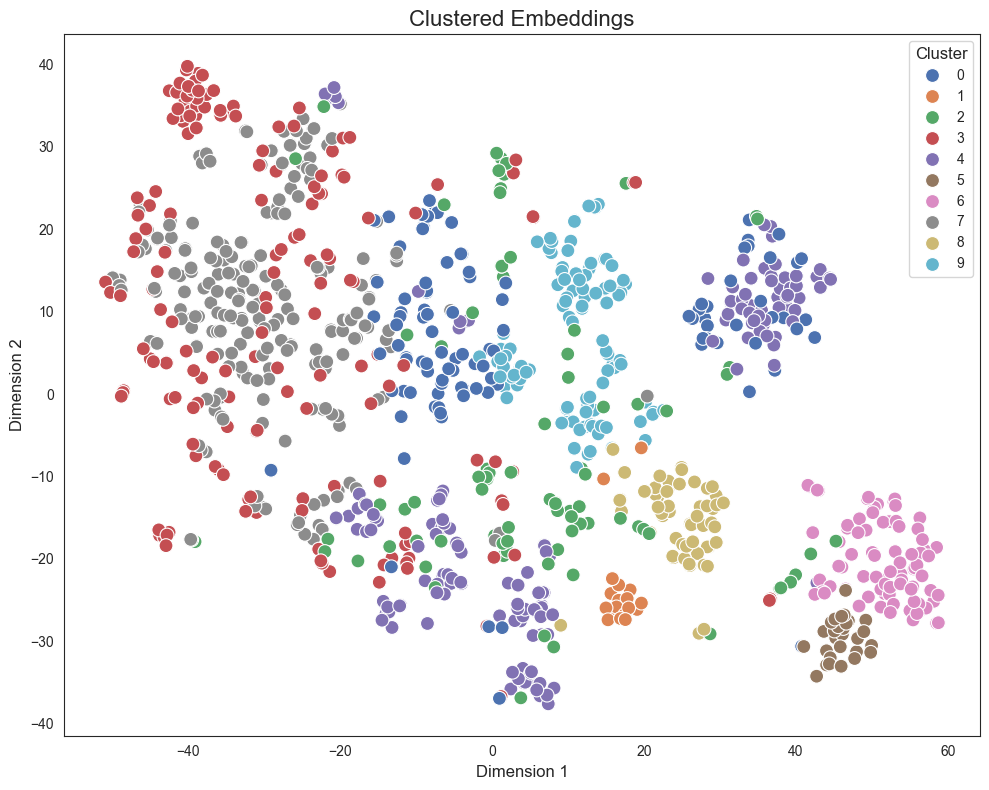

In [43]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Perform t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Set Seaborn style for better aesthetics
sns.set_style("white")

# Plot the reduced data with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_data_tsne[:, 0],
    y=reduced_data_tsne[:, 1],
    hue=cluster_labels,
    palette="deep",
    s=100
)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.title("Clustered Embeddings", fontsize=16)
plt.legend(title="Cluster", title_fontsize=12)

# Set background color
plt.gcf().patch.set_facecolor("white")

plt.tight_layout()
plt.show()

Explanation:
- `TSNE` reduces the dimensionality of the document vectors for visualization purposes.
- Each point represents a document, colored by its cluster label.

**4. Select Representative Documents from Each Cluster**

- The document closest to the cluster centroid is selected as the representative document for that cluster.

In [44]:
# List to store the indices of the closest documents for each cluster
closest_indices = []

# Identify the closest document for each cluster
for i in range(num_clusters):
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    closest_index = np.argmin(distances)
    closest_indices.append(closest_index)

# Sort the indices for sequential processing
selected_indices = sorted(closest_indices)
selected_indices


[68, 247, 459, 526, 585, 591, 681, 723, 810, 941]

Explanation:
- For each cluster, the document closest to the cluster center is identified.
- The indices are sorted to ensure sequential summarization later.

**5. Convert Selected Documents to LangChain Document Format**

- The selected documents are converted to LangChain's `Document` format for compatibility with the summarization chain.

In [45]:
from langchain_core.documents import Document

# Convert the selected documents into LangChain's Document format
selected_docs = [Document(page_content=split_docs[doc]) for doc in selected_indices]
selected_docs

[Document(metadata={}, page_content='35\nArtificial Intelligence\nIndex Report 2024 Chapter 1 Preview Table of Contents75.48%\n14.06%\n5.60%\n4.87%75.63%\n9.47%\n9.28%\n5.62%81.75%\n10.05%7.39%\n0.80%\n0% 10% 20% 30% 40% 50% 60% 70% 80%Nonpr otGovernmentIndustryEducation\nUnited S tates\nEuropean U nion and U nited Kingdom\nChina\nAI public ations (% of t otal)AI p ublic ations (% of t otal) b y sector and geogr aphic ar ea, 20 22\nSource: Center for Security and E merging T echnolog y, 2023 | C hart: 202 4 AI Inde x repor t1.1 PublicationsChapter 1: Research and Development\nFigure 1.1.5Artificial Intelligence\nIndex Report 2024'),
 Document(metadata={}, page_content='132\nArtificial Intelligence\nIndex Report 2024 Chapter 2 Preview Table of ContentsChapter 2: Technical Performance Artificial Intelligence\nIndex Report 2024\n1.251.712.32\n0.93 0.961.391.602.44 2.494.01text-davinci-0 02\ntext-davinci-0 03\nGPT -3.5-turbo\nVicuna- 13b\nCodeLlama- 34b\nchat-bis on-0 01\nClaude-instant\nC

**6. Generate the Final Summary Using the Map-Refine Chain**

* The **Map-Refine Chain** is used to generate a refined summary from the selected representative documents.

In [46]:
# Generate a refined summary using the Map-Refine Chain
refined_summary = map_refine_chain.invoke(selected_docs)

# Print the final refined summary
print("\n========== Final Refined Summary ==========\n")
print(refined_summary)

The document presents the "Artificial Intelligence Index Report 2024," focusing on the landscape of AI research and development.
It highlights the distribution of AI publications across various sectors and geographic areas, with significant contributions from the United States, the European Union, and China.
The report indicates that the majority of AI publications come from the non-profit sector, followed by government and industry.
It emphasizes the growing importance of AI in education and its implications for future research and policy-making.
Additionally, a preview of Chapter 2 provides a comparative analysis of the technical performance of various AI models, showcasing advancements in capabilities from 2022 to 2023, particularly for models like GPT-4, Claude, and Vicuna-13b.
Overall, the report serves as a comprehensive overview of the current state of AI research and its global impact.

-----------------

The document presents the "Artificial Intelligence Index Report 2024," fo